In [1]:
import datetime
import os
from random import shuffle
import traceback
from typing import Union, List
import numpy as np
import pickle

import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

from pypfopt import EfficientSemivariance
#from pypfopt import EfficientCVaR

from rl_mestrado.stock.Stock import Stock
import ffn.core as ffn
import bt

from tsmoothie.smoother import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# plots of BT only work with this following command
%matplotlib inline

In [2]:
def save_to_pickle(path, variables):
    """Salva variáveis em arquivo .pickle
    
    Arguments:
        path {str}-- Caminho do arquivo 
        variables {list} -- Lista de variáveis a serem salvas 
    """
    with open(path, 'wb') as f:
        pickle.dump(variables, f)

def return_from_pickle(path):
    """Retorna variáveis de um arquivo .pickle
    
    Arguments:
        path {str}-- Caminho do arquivo 
    
    Returns:
        variables {list} -- Lista de variáveis
    """
    with open(path, 'rb') as f:
        # log(text = "Variables returned from path {}".format(path))
        return pickle.load(f)

In [3]:
# calculate probabilistic momentum between returns series of two assets (ex. market x bonds)
# probabilistic momentum can be defined as the probability or confidence that one asset (left) is going to outperform the other (right).
# lookback period: n days (not business days)
# p_currentDate = reference date - usually the current date 
def checkForProbMomentum(p_returns:pd.DataFrame, left_ticker: str, right_ticker: str, 
                         p_currentDate=pd.Timestamp, p_lookbackPeriod=66):
    
    v_startDate = p_currentDate - pd.DateOffset(days=p_lookbackPeriod)
    v_returns = p_returns.loc[ v_startDate:p_currentDate, [left_ticker,right_ticker] ]
        
    v_leftReturns = v_returns.iloc[:,0]
    v_rightReturns = v_returns.iloc[:,1]
        
    mom = ffn.calc_prob_mom(v_leftReturns, v_rightReturns)
     
    return mom       

In [4]:
def getSmoothedReturns(p_returns: pd.DataFrame, p_smooth_fraction: float = 0.50):
     
    v_smoothed_returns = pd.DataFrame(index=p_returns.index)
    smoother = SpectralSmoother(smooth_fraction=p_smooth_fraction, pad_len=20)
    for i_name in p_returns.columns:
        i_returns = p_returns[i_name].dropna()
        # spectral smoother does not works if the number of data points is odd
        if ( len(i_returns.index) % 2 ) != 0:
            i_returns = i_returns[1:]              # remove the first row in case of odd number of points
        smoother.smooth(i_returns.values)
        i_returns_smooth_array = smoother.smooth_data[0][:]
        i_returns_smooth_series = pd.Series(i_returns_smooth_array, index=i_returns.index, name=i_returns.name)
        v_smoothed_returns = pd.concat([v_smoothed_returns, i_returns_smooth_series], axis=1)
        
    return v_smoothed_returns 

In [5]:
def getBuyAndHoldStrategyReturns(p_returnsDf: pd.DataFrame, p_weightsDf: pd.DataFrame):
    
    indexes_list = list(p_returnsDf.index) + list(p_weightsDf.index)       # merge the indexes (timestamps) of the weights and returns Dataframes into a list
    indexes_set = set(indexes_list)                                        # remove the repeated indexes
    indexes_set = sorted(indexes_set)                                      # sort the indexes 
    v_weightsRdxDf = p_weightsDf.reindex(indexes_set, method='pad')  # reindexes weight DF with the following filling logic: propagate last valid observation forward to next valid 
    v_weightsRdxDf = v_weightsRdxDf.reindex(p_returnsDf.index)       #  reindexes weight DF according to the returns DF indexes
    # calculates pd.Series representing the daily total returns for the strategy
    calc = (p_returnsDf * v_weightsRdxDf)
    v_totalRetSeries = calc.sum(axis=1) + 1
    # get the daily cumulative return (pd.Series) for the strategy
    v_totalRetSeries.iloc[0] = 1                 # 1 + Ret_{port,t=0} = 1 - the total return for the timestamp t=0 is 1 
    v_cumRetSeries = v_totalRetSeries.cumprod()
    
    return v_totalRetSeries, v_cumRetSeries

In [14]:
def PyPortfolioOptimize(p_etfs: List[Stock], 
                        p_weeklyReturns:pd.DataFrame,
                        p_dateFrom: pd.Timestamp, p_dateTo: pd.Timestamp, 
                        p_minAssetLength: int = 66,
                        p_priceFiltering: bool = False, p_smoothingFactor: float = 0.75,
                        p_inSamplePeriod: int = 365, p_rollingPeriod: str = 'weekly', 
                        p_method: str = 'minVolatility',  p_maxBound: float = 1.0, 
                        verbose=True, p_solver: str = 'ECOS'):
    
    v_dateFromOutSample = p_dateFrom                                                     # ex: 2010-01-01
    v_dateToInSample = v_dateFromOutSample - pd.DateOffset(days=1)                       # ex: 2009-12-31  
    v_dateFromInSample = v_dateFromOutSample - pd.DateOffset(days=p_inSamplePeriod)     # ex: 2010-01-01 - 2 years = 2008-01-01  

    v_allEtfPricesDf = Stock.getAssetsAggregatedDf(p_etfs)                              # dataframe of etf's historical prices - etfs per columns
    v_allEtfReturnsDf = Stock.getAssetsReturnsDf(p_etfs, p_fillNa=False)                # dataFrame of returns for all universe of etfs - etfs per columns
    v_allEtfsIds = [a.id for a in p_etfs]
        
    v_weightsDf = pd.DataFrame(columns=v_allEtfsIds)                                # dataframe of portfolio weights - etfs per columns
    
    
    while (v_dateFromOutSample < p_dateTo):                                          
        
        #print(f'DEBUGGING for in-sample period: {v_dateFromInSample} -- {v_dateToInSample}')
             
        
        ### ------------------- Mandatory Steps of Asset Selection (pre-optimization steps)
        i_selectedEtfs = p_etfs   
        
        # remove assets that started after the last day of the in-sample period (v_dateToInSample); 
        # in addition, remove assets that started before the last day of the in-sample period but do not have enough days (p_minAssetLenght = 66 by default)
        # to be considered in the optimization process  
        i_removedEtfs = [a.id for a in i_selectedEtfs if len(a.dataFrame.loc[:v_dateToInSample]) < p_minAssetLength]   
        i_selectedEtfs = [a for a in i_selectedEtfs if a.id not in i_removedEtfs]
        #print(f'List of removed ETfs: {i_removedEtfs}')
        
        i_etfsIds = [s.id for s in i_selectedEtfs]
        v_etfPricesDf = v_allEtfPricesDf.loc[v_dateFromInSample:v_dateToInSample, i_etfsIds]
        v_etfReturnsDf = v_allEtfReturnsDf.loc[v_dateFromInSample:v_dateToInSample, i_etfsIds]
        
        v_pricesDf = v_etfPricesDf
        v_returnsDf = v_etfReturnsDf
            
        # removing RICs with NaN values 
        #v_pricesDf.dropna(axis='columns',inplace=True)
        
        #print(f'Number of RICs que restaram apos Procedimentos de Selecao e Filtragem (Remocao de Assets): {len(i_stocksIds)}')
        #v_pricesDf.info()
        
        # checking for columns (assets) having some NAN values 
        #bool_NAN_pricesDf = v_pricesDf.isnull().sum() > 0

        # printing the assets having NAN values  
        #v_NAN_assetList = [i for i in bool_NAN_pricesDf.index if bool_NAN_pricesDf[i]]
        #for i_asset in v_NAN_assetList:
           # print(f'asset: {i_asset}, total of non-NaN values: {v_pricesDf[i_asset].count()}')
            #print(f'asset: {i_asset}, number of NaN values: {v_pricesDf[i_asset].isna().sum()}')
        
        ### -------------- getting the portfolio (weight vector) for the corresponding insample period        
        
        if verbose == True:
            print(f'Starting calculating weights for period from: {v_dateFromInSample} to {v_dateToInSample}')
            print(f'SOLVER: {p_solver}')
            
        if p_priceFiltering:
            # estimating expected returns - returns a pd.Series that has the annualised mean (daily) return for each asset
            # drop NAN values if necessary 
            v_returnsDf_smoothed = getSmoothedReturns(p_returns=v_returnsDf, p_smooth_fraction=p_smoothingFactor)
            i_mu = expected_returns.mean_historical_return(v_returnsDf_smoothed, returns_data=True).dropna()
            # check if necessary to drop an asset from dataframe of historical prices
            dif = list(v_returnsDf_smoothed.columns.difference(i_mu.index))
            v_returnsDf_smoothed = v_returnsDf_smoothed.drop(dif, axis=1)
            i_S = risk_models.risk_matrix(v_returnsDf_smoothed, returns_data=True, method='ledoit_wolf_constant_variance')
        else:
            # estimating expected returns - returns a pd.Series that has the annualised mean (daily) return for each asset
            # drop NAN values if necessary 
            i_mu = expected_returns.mean_historical_return(v_pricesDf).dropna()      
            # check if necessary to drop an asset from dataframe of historical prices
            dif = list(v_pricesDf.columns.difference(i_mu.index))
            v_pricesDf = v_pricesDf.drop(dif, axis=1)
            # estimating covariance matrix - calculate the Ledoit-Wolf shrinkage estimate for a particular shrinkage target.
            i_S = risk_models.risk_matrix(v_pricesDf, method='ledoit_wolf_constant_variance')
            
        # Optimization Stage
        p_bounds = (0, 1)
        i_ef = EfficientFrontier(i_mu, i_S, weight_bounds=p_bounds, solver=p_solver, verbose=False)
        
        # -------------------------------------------------------------------------------------------------
        # calculate probabilistic momentum between market (SPY) x bonds (TAIL or TLT)
        tlt_index = i_ef.tickers.index("TLT.O")
        spy_index = i_ef.tickers.index("SPY")
        xlk_index = i_ef.tickers.index("XLK")
        #gld_index = i_ef.tickers.index("GLD")
        if 'TAIL.K' in v_returnsDf.columns:
            tail_index = i_ef.tickers.index("TAIL.K")
            mom_market = checkForProbMomentum(p_weeklyReturns, 'SPY', 'TAIL.K', v_dateToInSample, p_lookbackPeriod=60)
        else:
            mom_market = checkForProbMomentum(p_weeklyReturns, 'SPY', 'TLT.O', v_dateToInSample, p_lookbackPeriod=60)
        
        print(f'Market Momentum for {v_dateToInSample}: {mom_market}')
        print(p_maxBound)
        i_ef.add_constraint(lambda w: w[:] <= p_maxBound)
#         if mom_market > 0.5:
#             # add constraints
#             i_ef.add_constraint(lambda w: w[:] <= p_maxBound)          
#             i_ef.add_constraint(lambda w: w[tlt_index] == 0.00)
#             #i_ef.add_constraint(lambda w: w[gld_index] == 0.00)
#             if 'TAIL.K' in v_returnsDf.columns:
#                 i_ef.add_constraint(lambda w: w[tail_index] == 0.00)
#             i_ef.add_constraint(lambda w: w[xlk_index] >= 0.50)
                    
#         elif mom_market <= 0.5:
#             # add constraints
#             if 'TAIL.K' in v_returnsDf.columns:
#                 i_ef.add_constraint(lambda w: w[tlt_index] == 0.00)
#                 i_ef.add_constraint(lambda w: w[tail_index] >= 0.50)
#                 #i_ef.add_constraint(lambda w: w[gld_index] >= 0.20)
#             elif 'TAIL.K' not in v_returnsDf.columns:
#                 i_ef.add_constraint(lambda w: w[tlt_index] >= 0.50)
#                 #i_ef.add_constraint(lambda w: w[gld_index] >= 0.20)
               
        if p_method == 'maxSharpe':
            i_weights = i_ef.max_sharpe(risk_free_rate=0)
        elif p_method == 'minVolatility':
            i_weights = i_ef.min_volatility()
        
        # post-processing weights
        v_cleaned_weights = i_ef.clean_weights()
        v_weightsSeries = pd.Series(v_cleaned_weights)
        
        print(v_weightsSeries [v_weightsSeries > 0])
        print(f'-------------------------------------------------------------\n\n\n')
        
        ### -------------- getting the portfolio (weight vector) for the corresponding insample period        
        
        v_portSymbols = [s for s in v_weightsSeries.index]
        
        # the reference date for the optimized portfolio is the start date of the Out of Sample period (v_dateFromOutSample)
        i_weightsIndex = v_dateFromOutSample
        v_weightsDf.loc[i_weightsIndex, :] = 0
        # assign the portfolio weights to the dataframe in the corresponding date
        for i_symbol in v_portSymbols:
            v_weightsDf.loc[i_weightsIndex, i_symbol] = v_weightsSeries.loc[i_symbol]
        
        
        ### ----------------- update to the next insample period
        if p_rollingPeriod == 'monthly':
            v_dateFromOutSample = v_dateFromOutSample + pd.DateOffset(months=1)
        elif p_rollingPeriod == 'weekly':
            v_dateFromOutSample = v_dateFromOutSample + pd.DateOffset(weeks=1)
        elif p_rollingPeriod == 'quarterly':
            v_dateFromOutSample = v_dateFromOutSample + pd.DateOffset(months=3)
        
        v_dateFromInSample = v_dateFromOutSample - pd.DateOffset(days=p_inSamplePeriod)
        v_dateToInSample = v_dateFromOutSample - pd.DateOffset(days=1)
        
    # end while
    
    if verbose == True:
        print(f'Optimization Finished!\n')

    # -----------------------
    # get the slice of the dataFrame of returns corresponding to the backtesting period (ex: v_dateFrom: 2010-01-01 - v_dateTo: 2020-11-23)
    
    v_etfReturnsDf = v_allEtfReturnsDf.loc[p_dateFrom:p_dateTo]
    
    v_totalRetSeries, v_cumRetSeries = getBuyAndHoldStrategyReturns(v_etfReturnsDf,v_weightsDf)
    
    return v_cumRetSeries 

    

In [12]:
# get all ETFs (daily prices)

# get a list of Stocks (object) from Eikon US - folder containing all ETFs -> p_exchange='US_ETFs'
p_folderName='US_ETFs'    # name of folder where the database is kept 
v_etfsList = Stock.getStocksFromFiles(p_database='eikon', p_number=None, p_exchange=p_folderName, p_shuffle=False, data_path='../data')

# select which ETFs from the ETF universe will participate of the strategy 
v_ricList = ['SPY', 'TLT.O', 'TAIL.K', 'XLK']
v_ricList = ['SPY', 'TLT.O', 'XLK']

v_etfsSelList = [a for a in v_etfsList if a.id in v_ricList]

df_prices = Stock.getAssetsAggregatedDf(p_assetsList = v_etfsSelList, p_column = 'close')

df_prices

,SPY,TLT.O,XLK
2002-01-02,115.53,NaN,24.60
2002-01-03,116.84,NaN,25.68
2002-01-04,117.62,NaN,25.84
2002-01-07,116.79,NaN,25.56
2002-01-08,116.52,NaN,25.75
...,...,...,...
2021-09-24,443.91,146.91,156.71
2021-09-27,442.64,146.37,155.19
2021-09-28,433.72,144.09,150.59
2021-09-29,434.45,144.34,150.40


In [8]:
# weekly returns - will be used only for computing the probabilistic momentum between market (SPY) and bonds (TLT or TAIL)
df_weeklyPrices = pd.read_csv('../raw/raw_weekly_prices.csv', parse_dates=True, index_col=0)
df_weeklyReturns = df_weeklyPrices.pct_change(axis=0)
df_weeklyReturns

,XLK,SPY,TLT.O,TAIL.K,VIX
2002-01-04,NaN,NaN,NaN,NaN,NaN
2002-01-11,0.003416,-0.005857,NaN,NaN,0.031256
2002-01-18,-0.035899,-0.018779,NaN,NaN,0.032834
2002-01-25,-0.039151,-0.005444,NaN,NaN,-0.043122
2002-02-01,-0.003689,-0.007196,NaN,NaN,0.012390
...,...,...,...,...,...
2021-09-03,0.010492,0.009466,-0.000523,-2.664961e-03,-0.055446
2021-09-10,-0.005389,-0.007017,-0.005454,9.619496e-04,0.161918
2021-09-17,-0.008635,-0.008365,0.011906,3.256807e-03,0.017904
2021-09-24,-0.015005,-0.015526,-0.001440,-2.220446e-16,0.112009


In [15]:
# define the period of Backtesting 
v_dateFrom = pd.Timestamp('2015-01-05')          # should be a monday  
v_dateFromStr = v_dateFrom.strftime('%Y-%m-%d')
v_dateTo = pd.Timestamp('2021-09-30')
v_dateToStr = v_dateTo.strftime('%Y-%m-%d')

# ------------------------------------------------------
# strategy parameters 

# assets selection
v_priceFiltering = True                # flag that activates filtering of the historical prices dataFrame (via tsmoothie)
v_smoothingFactor = 0.75
v_minAssetLength = 66                  # minimum sample size (days) to be considered in the optimization process (in business days)

# portfolio optimization
v_solver = 'ECOS'
#v_solver = 'OSQP'
#v_solver = 'SCS'
v_inSamplePeriod = 365*2                # 2 years
#v_rollingPeriod = 'monthly'                  
#v_rollingPeriod = 'quarterly'
v_rollingPeriod = 'weekly'             
v_method = ['minVolatility','maxSharpe']
#v_method = ['minVolatility']
v_maxBound = 1.0                # max bound for stock weights in the portfolio

# strategy properties
v_strategyProperties = f'LongOnly_From_{v_dateFromStr}_To_{v_dateToStr}' \
+ f'_Model_MeanVariance' \
+ f'_{"PriceFiltering" if v_priceFiltering else "NoPriceFiltering"}' \
+ f'{v_smoothingFactor if v_priceFiltering else ""}' \
+ f'_InSmp{v_inSamplePeriod}d_Roll{v_rollingPeriod}' 

print(v_strategyProperties)

v_savingPath=f'Backtesting_Files/{v_strategyProperties}.pkl'

strategies_dict = {}
v_errors = []

for i_method in v_method:
        
    if i_method == 'minVolatility':
        i_metStr = 'minVol'
    elif i_method == 'maxSharpe':
        i_metStr = i_method
    keyName =  f'{i_metStr}'
        
    try:
        print(f'--------------------------------------------------------------\n')
        print(f'Starting Backtesting from {v_dateFrom} to {v_dateTo}\n')
        print(f'Strategy Name: {keyName} - Solver: {v_solver} \n')
        print(f'--------------------------------------------------------------\n')

        v_cumReturnsSeries = PyPortfolioOptimize(p_etfs=v_etfsSelList,
                                                 p_weeklyReturns = df_weeklyReturns,
                                                 p_dateFrom=v_dateFrom,
                                                 p_dateTo=v_dateTo,
                                                 p_priceFiltering=v_priceFiltering,
                                                 p_smoothingFactor=v_smoothingFactor, 
                                                 p_minAssetLength=v_minAssetLength,  
                                                 verbose=True,
                                                 p_inSamplePeriod=v_inSamplePeriod,
                                                 p_rollingPeriod=v_rollingPeriod,
                                                 p_method=i_method,
                                                 p_maxBound=v_maxBound,
                                                 p_solver = v_solver)
        # if optimization was successfull, then insert strategy's cumulative returns into dict 
        strategies_dict[keyName] = v_cumReturnsSeries
    
    except:
        traceback.print_exc()
        print(f'Error for {keyName}')
        v_errors.append(keyName)
            
              
print(f'Errors for portfolios: {v_errors}')

#save_to_pickle(v_savingPath, strategies_dict)


LongOnly_From_2015-01-05_To_2021-09-30_Model_MeanVariance_PriceFiltering0.75_InSmp730d_Rollweekly
--------------------------------------------------------------

Starting Backtesting from 2015-01-05 00:00:00 to 2021-09-30 00:00:00

Strategy Name: minVol - Solver: ECOS 

--------------------------------------------------------------

Starting calculating weights for period from: 2013-01-05 00:00:00 to 2015-01-04 00:00:00
SOLVER: ECOS
Market Momentum for 2015-01-04 00:00:00: 0.4752359536288395
1.0
SPY      0.41755
TLT.O    0.46299
XLK      0.11946
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-01-12 00:00:00 to 2015-01-11 00:00:00
SOLVER: ECOS
Market Momentum for 2015-01-11 00:00:00: 0.3649818807264693
1.0
SPY      0.41463
TLT.O    0.46592
XLK      0.11945
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-01-19 00:00:00 to 20

SPY      0.51549
TLT.O    0.48451
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-09-14 00:00:00 to 2015-09-13 00:00:00
SOLVER: ECOS
Market Momentum for 2015-09-13 00:00:00: 0.378261485893057
1.0
SPY      0.51624
TLT.O    0.48376
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-09-21 00:00:00 to 2015-09-20 00:00:00
SOLVER: ECOS
Market Momentum for 2015-09-20 00:00:00: 0.3270525985330486
1.0
SPY      0.51494
TLT.O    0.48506
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-09-28 00:00:00 to 2015-09-27 00:00:00
SOLVER: ECOS
Market Momentum for 2015-09-27 00:00:00: 0.32144767866227686
1.0
SPY      0.51574
TLT.O    0.48426
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 

SPY      0.48383
TLT.O    0.51617
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-05-10 00:00:00 to 2016-05-08 00:00:00
SOLVER: ECOS
Market Momentum for 2016-05-08 00:00:00: 0.5970215916225337
1.0
SPY      0.48389
TLT.O    0.51611
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-05-17 00:00:00 to 2016-05-15 00:00:00
SOLVER: ECOS
Market Momentum for 2016-05-15 00:00:00: 0.5311407973657429
1.0
SPY      0.483
TLT.O    0.517
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-05-24 00:00:00 to 2016-05-22 00:00:00
SOLVER: ECOS
Market Momentum for 2016-05-22 00:00:00: 0.47715561406188456
1.0
SPY      0.48264
TLT.O    0.51736
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 201

SPY      0.50385
TLT.O    0.49615
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-01-17 00:00:00 to 2017-01-15 00:00:00
SOLVER: ECOS
Market Momentum for 2017-01-15 00:00:00: 0.6685557536088924
1.0
SPY      0.50367
TLT.O    0.49633
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-01-24 00:00:00 to 2017-01-22 00:00:00
SOLVER: ECOS
Market Momentum for 2017-01-22 00:00:00: 0.6197441161776772
1.0
SPY      0.50112
TLT.O    0.49888
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-01-31 00:00:00 to 2017-01-29 00:00:00
SOLVER: ECOS
Market Momentum for 2017-01-29 00:00:00: 0.6184908979683454
1.0
SPY      0.50309
TLT.O    0.49691
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 

Market Momentum for 2017-09-10 00:00:00: 0.4014129054478275
1.0
SPY      0.49665
TLT.O    0.50335
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-09-19 00:00:00 to 2017-09-17 00:00:00
SOLVER: ECOS
Market Momentum for 2017-09-17 00:00:00: 0.4862415505862743
1.0
SPY      0.49764
TLT.O    0.50236
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-09-26 00:00:00 to 2017-09-24 00:00:00
SOLVER: ECOS
Market Momentum for 2017-09-24 00:00:00: 0.512608041981241
1.0
SPY      0.49656
TLT.O    0.50344
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-10-03 00:00:00 to 2017-10-01 00:00:00
SOLVER: ECOS
Market Momentum for 2017-10-01 00:00:00: 0.49235126719311295
1.0
SPY      0.50677
TLT.O    0.49323
dtype: float64
-----------------------------------------------

Market Momentum for 2018-05-13 00:00:00: 0.4555942035389947
1.0
SPY      0.48693
TLT.O    0.51307
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-05-21 00:00:00 to 2018-05-20 00:00:00
SOLVER: ECOS
Market Momentum for 2018-05-20 00:00:00: 0.513205500657935
1.0
SPY      0.48945
TLT.O    0.51055
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-05-28 00:00:00 to 2018-05-27 00:00:00
SOLVER: ECOS
Market Momentum for 2018-05-27 00:00:00: 0.5861331470319542
1.0
SPY      0.49202
TLT.O    0.50798
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-06-04 00:00:00 to 2018-06-03 00:00:00
SOLVER: ECOS
Market Momentum for 2018-06-03 00:00:00: 0.5770830920621786
1.0
SPY      0.49085
TLT.O    0.50915
dtype: float64
------------------------------------------------

Market Momentum for 2019-01-06 00:00:00: 0.3165155693233216
1.0
SPY      0.36008
TLT.O    0.63992
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-01-14 00:00:00 to 2019-01-13 00:00:00
SOLVER: ECOS
Market Momentum for 2019-01-13 00:00:00: 0.3260074417488457
1.0
SPY      0.3601
TLT.O    0.6399
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-01-21 00:00:00 to 2019-01-20 00:00:00
SOLVER: ECOS
Market Momentum for 2019-01-20 00:00:00: 0.39812975914700743
1.0
SPY      0.35761
TLT.O    0.64239
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-01-28 00:00:00 to 2019-01-27 00:00:00
SOLVER: ECOS
Market Momentum for 2019-01-27 00:00:00: 0.4400813067438605
1.0
SPY      0.35384
TLT.O    0.64616
dtype: float64
------------------------------------------------

Market Momentum for 2019-08-18 00:00:00: 0.35010183079948454
1.0
SPY      0.35378
TLT.O    0.64622
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-08-26 00:00:00 to 2019-08-25 00:00:00
SOLVER: ECOS
Market Momentum for 2019-08-25 00:00:00: 0.36242861045652613
1.0
SPY      0.35628
TLT.O    0.64372
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-09-02 00:00:00 to 2019-09-01 00:00:00
SOLVER: ECOS
Market Momentum for 2019-09-01 00:00:00: 0.3475682803865523
1.0
SPY      0.35665
TLT.O    0.64335
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-09-09 00:00:00 to 2019-09-08 00:00:00
SOLVER: ECOS
Market Momentum for 2019-09-08 00:00:00: 0.3631097041651652
1.0
SPY      0.35382
TLT.O    0.64618
dtype: float64
---------------------------------------------

SPY      0.44774
TLT.O    0.55226
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-04-14 00:00:00 to 2020-04-12 00:00:00
SOLVER: ECOS
Market Momentum for 2020-04-12 00:00:00: 0.2952606861599285
1.0
SPY      0.44284
TLT.O    0.55716
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-04-21 00:00:00 to 2020-04-19 00:00:00
SOLVER: ECOS
Market Momentum for 2020-04-19 00:00:00: 0.3116351398063556
1.0
SPY      0.44309
TLT.O    0.55691
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-04-28 00:00:00 to 2020-04-26 00:00:00
SOLVER: ECOS
Market Momentum for 2020-04-26 00:00:00: 0.30543884021877454
1.0
SPY      0.43877
TLT.O    0.56123
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from:

Market Momentum for 2020-11-22 00:00:00: 0.6168072047908097
1.0
SPY      0.43281
TLT.O    0.56719
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-12-01 00:00:00 to 2020-11-29 00:00:00
SOLVER: ECOS
Market Momentum for 2020-11-29 00:00:00: 0.6917004579505535
1.0
SPY      0.43294
TLT.O    0.56706
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-12-08 00:00:00 to 2020-12-06 00:00:00
SOLVER: ECOS
Market Momentum for 2020-12-06 00:00:00: 0.6893911543820539
1.0
SPY      0.43703
TLT.O    0.56297
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-12-15 00:00:00 to 2020-12-13 00:00:00
SOLVER: ECOS
Market Momentum for 2020-12-13 00:00:00: 0.6433913486318987
1.0
SPY      0.43766
TLT.O    0.56234
dtype: float64
-----------------------------------------------

Market Momentum for 2021-07-25 00:00:00: 0.32425881084140973
1.0
SPY      0.45458
TLT.O    0.54542
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-08-03 00:00:00 to 2021-08-01 00:00:00
SOLVER: ECOS
Market Momentum for 2021-08-01 00:00:00: 0.4159759729975751
1.0
SPY      0.45321
TLT.O    0.54679
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-08-10 00:00:00 to 2021-08-08 00:00:00
SOLVER: ECOS
Market Momentum for 2021-08-08 00:00:00: 0.3858794138812398
1.0
SPY      0.45651
TLT.O    0.54349
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-08-17 00:00:00 to 2021-08-15 00:00:00
SOLVER: ECOS
Market Momentum for 2021-08-15 00:00:00: 0.5235636701894796
1.0
SPY      0.45616
TLT.O    0.54384
dtype: float64
----------------------------------------------

SPY      0.20979
TLT.O    0.24041
XLK      0.54979
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-06-22 00:00:00 to 2015-06-21 00:00:00
SOLVER: ECOS
Market Momentum for 2015-06-21 00:00:00: 0.7078682356666617
1.0
SPY      0.31336
TLT.O    0.31631
XLK      0.37034
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-06-29 00:00:00 to 2015-06-28 00:00:00
SOLVER: ECOS
Market Momentum for 2015-06-28 00:00:00: 0.7104696919648533
1.0
SPY      0.28324
TLT.O    0.26419
XLK      0.45257
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-07-06 00:00:00 to 2015-07-05 00:00:00
SOLVER: ECOS
Market Momentum for 2015-07-05 00:00:00: 0.6079119467276848
1.0
SPY      0.26205
TLT.O    0.32601
XLK      0.41194
dtype: float64
-------------------------------------------

TLT.O    0.61584
XLK      0.38416
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-02-15 00:00:00 to 2016-02-14 00:00:00
SOLVER: ECOS
Market Momentum for 2016-02-14 00:00:00: 0.24892539219207271
1.0
TLT.O    0.652
XLK      0.348
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-02-22 00:00:00 to 2016-02-21 00:00:00
SOLVER: ECOS
Market Momentum for 2016-02-21 00:00:00: 0.3569387989871287
1.0
TLT.O    0.61935
XLK      0.38065
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-03-01 00:00:00 to 2016-02-28 00:00:00
SOLVER: ECOS
Market Momentum for 2016-02-28 00:00:00: 0.36603082424732314
1.0
TLT.O    0.60595
XLK      0.39405
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 20

TLT.O    0.57174
XLK      0.42826
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-09-27 00:00:00 to 2016-09-25 00:00:00
SOLVER: ECOS
Market Momentum for 2016-09-25 00:00:00: 0.574694240816297
1.0
TLT.O    0.5591
XLK      0.4409
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-10-04 00:00:00 to 2016-10-02 00:00:00
SOLVER: ECOS
Market Momentum for 2016-10-02 00:00:00: 0.5316772788361344
1.0
TLT.O    0.54206
XLK      0.45794
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-10-11 00:00:00 to 2016-10-09 00:00:00
SOLVER: ECOS
Market Momentum for 2016-10-09 00:00:00: 0.5796488051725794
1.0
TLT.O    0.47384
XLK      0.52616
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 201

Market Momentum for 2017-05-07 00:00:00: 0.4840718479070478
1.0
TLT.O    0.22684
XLK      0.77316
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-05-16 00:00:00 to 2017-05-14 00:00:00
SOLVER: ECOS
Market Momentum for 2017-05-14 00:00:00: 0.4643154725969481
1.0
TLT.O    0.2574
XLK      0.7426
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-05-23 00:00:00 to 2017-05-21 00:00:00
SOLVER: ECOS
Market Momentum for 2017-05-21 00:00:00: 0.4117343238681538
1.0
TLT.O    0.34101
XLK      0.65899
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-05-30 00:00:00 to 2017-05-28 00:00:00
SOLVER: ECOS
Market Momentum for 2017-05-28 00:00:00: 0.5052733418899111
1.0
TLT.O    0.31969
XLK      0.68031
dtype: float64
-------------------------------------------------

SPY      0.10753
TLT.O    0.25924
XLK      0.63323
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-12-26 00:00:00 to 2017-12-24 00:00:00
SOLVER: ECOS
Market Momentum for 2017-12-24 00:00:00: 0.6650075775629867
1.0
SPY      0.05276
TLT.O    0.22530
XLK      0.72194
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-01-02 00:00:00 to 2017-12-31 00:00:00
SOLVER: ECOS
Market Momentum for 2017-12-31 00:00:00: 0.5666501135705787
1.0
SPY      0.16396
TLT.O    0.25130
XLK      0.58474
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-01-09 00:00:00 to 2018-01-07 00:00:00
SOLVER: ECOS
Market Momentum for 2018-01-07 00:00:00: 0.6622607197317663
1.0
SPY      0.21988
TLT.O    0.20118
XLK      0.57893
dtype: float64
-------------------------------------------

Market Momentum for 2018-09-09 00:00:00: 0.7412625074529979
1.0
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-09-17 00:00:00 to 2018-09-16 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-16 00:00:00: 0.7252938600499017
1.0
SPY    0.06903
XLK    0.93097
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-09-24 00:00:00 to 2018-09-23 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-23 00:00:00: 0.7408006790110997
1.0
SPY    0.06471
XLK    0.93529
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-10-01 00:00:00 to 2018-09-30 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-30 00:00:00: 0.6836264084645067
1.0
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for per

Market Momentum for 2019-04-07 00:00:00: 0.607164210470619
1.0
TLT.O    0.40109
XLK      0.59891
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-04-15 00:00:00 to 2019-04-14 00:00:00
SOLVER: ECOS
Market Momentum for 2019-04-14 00:00:00: 0.5960459994823661
1.0
TLT.O    0.27865
XLK      0.72135
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-04-22 00:00:00 to 2019-04-21 00:00:00
SOLVER: ECOS
Market Momentum for 2019-04-21 00:00:00: 0.6087150291425139
1.0
TLT.O    0.3058
XLK      0.6942
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-04-29 00:00:00 to 2019-04-28 00:00:00
SOLVER: ECOS
Market Momentum for 2019-04-28 00:00:00: 0.5858838489562767
1.0
TLT.O    0.3965
XLK      0.6035
dtype: float64
----------------------------------------------------

Market Momentum for 2019-12-22 00:00:00: 0.7614207542736506
1.0
TLT.O    0.56254
XLK      0.43746
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-12-30 00:00:00 to 2019-12-29 00:00:00
SOLVER: ECOS
Market Momentum for 2019-12-29 00:00:00: 0.743822570715139
1.0
TLT.O    0.56578
XLK      0.43422
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-01-06 00:00:00 to 2020-01-05 00:00:00
SOLVER: ECOS
Market Momentum for 2020-01-05 00:00:00: 0.7114599785836873
1.0
TLT.O    0.58751
XLK      0.41249
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-01-13 00:00:00 to 2020-01-12 00:00:00
SOLVER: ECOS
Market Momentum for 2020-01-12 00:00:00: 0.6654193130762325
1.0
TLT.O    0.58087
XLK      0.41913
dtype: float64
------------------------------------------------

Market Momentum for 2020-07-19 00:00:00: 0.6700525253378582
1.0
TLT.O    0.61535
XLK      0.38465
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-07-28 00:00:00 to 2020-07-26 00:00:00
SOLVER: ECOS
Market Momentum for 2020-07-26 00:00:00: 0.6288182724797768
1.0
TLT.O    0.61668
XLK      0.38332
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-08-04 00:00:00 to 2020-08-02 00:00:00
SOLVER: ECOS
Market Momentum for 2020-08-02 00:00:00: 0.5514405613434745
1.0
TLT.O    0.61576
XLK      0.38424
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-08-11 00:00:00 to 2020-08-09 00:00:00
SOLVER: ECOS
Market Momentum for 2020-08-09 00:00:00: 0.49216102067243894
1.0
TLT.O    0.60518
XLK      0.39482
dtype: float64
----------------------------------------------

Market Momentum for 2021-02-21 00:00:00: 0.7992586566825948
1.0
TLT.O    0.44314
XLK      0.55686
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-03-02 00:00:00 to 2021-02-28 00:00:00
SOLVER: ECOS
Market Momentum for 2021-02-28 00:00:00: 0.8331342900864165
1.0
TLT.O    0.46014
XLK      0.53986
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-03-09 00:00:00 to 2021-03-07 00:00:00
SOLVER: ECOS
Market Momentum for 2021-03-07 00:00:00: 0.8185996665545012
1.0
TLT.O    0.42992
XLK      0.57008
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-03-16 00:00:00 to 2021-03-14 00:00:00
SOLVER: ECOS
Market Momentum for 2021-03-14 00:00:00: 0.8163227343618938
1.0
TLT.O    0.41557
XLK      0.58443
dtype: float64
-----------------------------------------------

TLT.O    0.31774
XLK      0.68226
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-09-28 00:00:00 to 2021-09-26 00:00:00
SOLVER: ECOS
Market Momentum for 2021-09-26 00:00:00: 0.5250049618489351
1.0
TLT.O    0.29739
XLK      0.70261
dtype: float64
-------------------------------------------------------------



Optimization Finished!

Errors for portfolios: []


              minVol  maxSharpe
2015-01-05  1.000000   1.000000
2015-01-06  1.002969   0.998305
2015-01-07  1.008285   1.005984
2015-01-08  1.012221   1.015224
2015-01-09  1.013587   1.013401
...              ...        ...
2021-09-24  1.696204   2.309245
2021-09-27  1.690597   2.290983
2021-09-28  1.660750   2.232658
2021-09-29  1.663592   2.231831
2021-09-30  1.654231   2.220478

[1698 rows x 2 columns]


<AxesSubplot:>

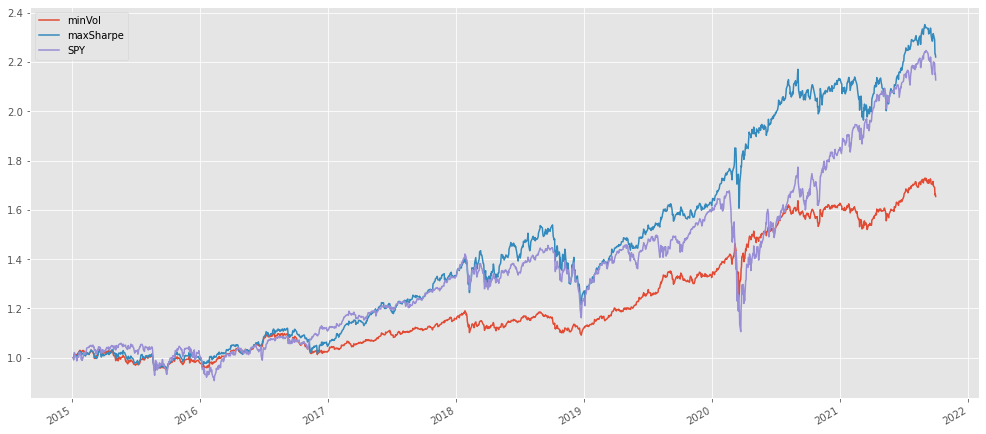

In [16]:
v_stratDf = pd.DataFrame.from_dict(strategies_dict)
print(v_stratDf)

# get the bechmark series
p_folderName='US_benchmarks'    # name of folder where the database is kept 
v_benchList = Stock.getStocksFromFiles(p_database='eikon', p_number=None, p_exchange=p_folderName, p_shuffle=False, data_path='../data')
v_benchPricesDf = Stock.getAssetsAggregatedDf(v_benchList)  
v_benchPricesDf = v_benchPricesDf.loc[v_stratDf.index[0]:v_stratDf.index[-1]]
v_benchPricesDf = v_benchPricesDf / v_benchPricesDf.iloc[0]

# insert benchmark into the dataFrame of all strategies
v_stratDf = pd.concat([v_stratDf, v_benchPricesDf], axis=1)

# plot curves for the best strategies
#v_stratDf = v_stratDf.rebase(1)
strDateFrom = v_dateFrom.strftime('%Y-%m-%d')
strDateTo = v_dateTo.strftime('%Y-%m-%d')
graphTitle = f'Comparison of the best strategies from {strDateFrom} to {strDateTo}'
v_stratDf.plot(figsize=(17,8))

In [ ]:
# v_stratDf.to_csv("../results/backtest/baseline.csv", index=True)

In [22]:
v_stratDf = v_stratDf.rename(columns={'maxSharpe': 'maxSharpeBasic', 'minVol': 'minVolBasic'})
v_stratDf.to_csv("../results/backtest/baseline2.csv", index=True)

In [23]:
# calculating the stats for the best strategies 
statsStrat = v_stratDf.calc_stats()
statsStrat.display()

Stat                 minVolBasic    maxSharpeBasic    SPY
-------------------  -------------  ----------------  ----------
Start                2015-01-05     2015-01-05        2015-01-05
End                  2021-09-30     2021-09-30        2021-09-30
Risk-free rate       0.00%          0.00%             0.00%

Total Return         65.42%         122.05%           112.74%
Daily Sharpe         0.89           0.97              0.72
Daily Sortino        1.38           1.50              1.07
CAGR                 7.76%          12.57%            11.86%
Max Drawdown         -14.82%        -21.11%           -34.10%
Calmar Ratio         0.52           0.60              0.35

MTD                  -3.88%         -5.06%            -4.97%
3m                   0.22%          0.82%             0.25%
6m                   7.40%          11.14%            8.72%
YTD                  1.68%          4.16%             14.78%
1Y                   4.68%          6.83%             28.14%
3Y (ann.)           

In [13]:
type(v_stratDf)

pandas.core.frame.DataFrame

In [13]:
### ----------- in case of Errors in the optimization process, try with alternative solvers
#solversList = ['OSQP', 'SCS']

#i_solver = 'OSQP' 
#i_method = 'MaxSharpe'
#i_bound = 0.1

#v_bounds = (0, i_bound)
        
#if i_method == 'minVolatility':
#    i_metStr = 'minVol'
#elif i_method == 'maxSharpe':
#    i_metStr = i_method
#keyName =  f'{i_metStr}_{i_bound}'

#v_errors.pop(0) # remove the first item from v_errors

#try:
#    print(f'--------------------------------------------------------------\n')
#    print(f'Starting Backtesting from {v_dateFrom} to {v_dateTo}\n')
#    print(f'Strategy Name: {keyName} - Solver: {i_solver} \n')
#    print(f'--------------------------------------------------------------\n')

#    v_cumReturnsSeries = PyPortfolioOptimize(p_assets=v_assetsList, 
#                                             p_compositionsSeries=v_compositionsSeries,
#                                             p_dateFrom=v_dateFrom,
#                                             p_dateTo=v_dateTo,
#                                             p_selectByComposition=v_selectByComposition,
#                                             p_selectByReturn=v_selectByReturn,
#                                             p_minAssetLength = v_minAssetLength,  
#                                             verbose=True,
#                                             p_inSamplePeriod=v_inSamplePeriod,
#                                             p_rollingPeriod=v_rollingPeriod,
#                                             p_method=i_method,
#                                             p_bounds=v_bounds,
#                                             p_solver = i_solver)
#    if optimization was successfull, then insert strategy's cumulative returns into dict 
#    strategies_dict[keyName] = v_cumReturnsSeries
    
#except:
#    traceback.print_exc()
#    print(f'Error for {keyName}')
#    v_errors.append(keyName)
        
        
#print(f'Errors for portfolios: {v_errors}')
    
#if len(v_errors) == 0: 
    #save_to_pickle(v_savingPath, strategies_dict)